In [2]:
import pandas as pd
import seaborn
import numpy as np
import cenpy
import geopandas as gpd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import altair as alt
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN

## DATA

In [3]:
acs = cenpy.remote.APIConnection("ACSDT5Y2014")

In [4]:
##columns:
##
variables = ["B09019_003E","B09019_002E", 
             "B11001_006E","B25044_001E",
             "B25044_003E","B25044_010E",
             "B09019_008E","B09019_022E",
             "B09019_036E","B11001_001E"]
pastatecode = "42"
countycode = "101"
tracts = acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state" : "42",
                "county": "101"},
)

tracts[variables] = tracts[variables].astype(float)


In [5]:
tracts = tracts.rename(columns={'B09019_002E': 'tot_pop_hh', #total population in households
                                'B11001_001E': 'tot_hh', #total number of households
                                            'B09019_003E': 'tot_pop_fhh', #total population in family households
                                            'B09019_008E': 'pop_fhh_child', #total population of children in family households
                                            'B09019_022E': 'pop_fhh_fchild', #total population of foster children in family households
                                            'B09019_036E': 'pop_nf_fchild', #total population of foster children in non-family households
                                           'B11001_006E': 'pop_fhh_fem', #population in family households that is female heads of household, no husband present
                                           'B25044_001E': 'tot_units', #total occupied housing units
                                           'B25044_003E': 'own_nv', #total owned occupied housing units with no access to vehicles
                                           'B25044_010E': 'rent_nv'}) #total rented occupied housing units with no access to vehicles
    
tracts.head()

,tot_pop_fhh,tot_pop_hh,pop_fhh_fem,tot_units,own_nv,rent_nv,pop_fhh_child,pop_fhh_fchild,pop_nf_fchild,tot_hh,state,county,tract,block group
0,1190.0,1283.0,73.0,350.0,52.0,81.0,442.0,0.0,0.0,350.0,42,101,002801,2
1,1238.0,1522.0,6.0,555.0,28.0,140.0,317.0,0.0,0.0,555.0,42,101,002801,3
2,1289.0,1430.0,70.0,417.0,88.0,102.0,443.0,0.0,0.0,417.0,42,101,002802,1
3,685.0,873.0,17.0,378.0,72.0,125.0,262.0,0.0,0.0,378.0,42,101,002802,2
4,898.0,1292.0,54.0,536.0,40.0,147.0,328.0,0.0,0.0,536.0,42,101,002802,3


In [6]:
#remove observations = 0 for total number of households
tracts.drop(tracts.loc[tracts['tot_hh']==0].index, inplace=True)
tracts.head()

,tot_pop_fhh,tot_pop_hh,pop_fhh_fem,tot_units,own_nv,rent_nv,pop_fhh_child,pop_fhh_fchild,pop_nf_fchild,tot_hh,state,county,tract,block group
0,1190.0,1283.0,73.0,350.0,52.0,81.0,442.0,0.0,0.0,350.0,42,101,002801,2
1,1238.0,1522.0,6.0,555.0,28.0,140.0,317.0,0.0,0.0,555.0,42,101,002801,3
2,1289.0,1430.0,70.0,417.0,88.0,102.0,443.0,0.0,0.0,417.0,42,101,002802,1
3,685.0,873.0,17.0,378.0,72.0,125.0,262.0,0.0,0.0,378.0,42,101,002802,2
4,898.0,1292.0,54.0,536.0,40.0,147.0,328.0,0.0,0.0,536.0,42,101,002802,3


In [7]:
#create sum columns
tracts['hu_no_veh']=(tracts['own_nv']+tracts['rent_nv']) #total housing units w/o access to vehicles
tracts['pop_children']=(tracts['pop_fhh_child']+tracts['pop_fhh_fchild']+tracts['pop_nf_fchild']) #total population of children in households

tracts['percent_f_hh'] = (tracts['pop_fhh_fem']/tracts['tot_hh']) * 100 #percent of households with female householders
tracts['percent_children_hh'] = (tracts['pop_children']/tracts['tot_pop_hh']) * 100 #percent of children in households
tracts['percent_no_vehicle'] = (tracts['hu_no_veh']/tracts['tot_units']) * 100 #percent of units with no access to vehicles

tracts.head()

,tot_pop_fhh,tot_pop_hh,pop_fhh_fem,tot_units,own_nv,rent_nv,pop_fhh_child,pop_fhh_fchild,pop_nf_fchild,tot_hh,state,county,tract,block group,hu_no_veh,pop_children,percent_f_hh,percent_children_hh,percent_no_vehicle
0,1190.0,1283.0,73.0,350.0,52.0,81.0,442.0,0.0,0.0,350.0,42,101,002801,2,133.0,442.0,20.857143,34.450507,38.000000
1,1238.0,1522.0,6.0,555.0,28.0,140.0,317.0,0.0,0.0,555.0,42,101,002801,3,168.0,317.0,1.081081,20.827858,30.270270
2,1289.0,1430.0,70.0,417.0,88.0,102.0,443.0,0.0,0.0,417.0,42,101,002802,1,190.0,443.0,16.786571,30.979021,45.563549
3,685.0,873.0,17.0,378.0,72.0,125.0,262.0,0.0,0.0,378.0,42,101,002802,2,197.0,262.0,4.497354,30.011455,52.116402
4,898.0,1292.0,54.0,536.0,40.0,147.0,328.0,0.0,0.0,536.0,42,101,002802,3,187.0,328.0,10.074627,25.386997,34.888060


## GEOMETRIES

In [8]:
tract_boundaries = gpd.read_file('/Users/camilleboggan/Documents/University of Pennsylvania/Fall 2020/Thesis/data/Census_Block_Groups_2010.geojson')
tract_boundaries = tract_boundaries.to_crs(epsg=3857)
tract_boundaries.head()

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Shape__Area,Shape__Length,geometry
0,1,42,101,010800,1,421010108001,Block Group 1,G5030,S,161887,0,+39.9687580,-075.1997251,1.742508e+06,8200.327170,"POLYGON ((-8371060.374 4861503.694, -8370941.2..."
1,2,42,101,010800,2,421010108002,Block Group 2,G5030,S,103778,0,+39.9665475,-075.2004455,1.117026e+06,4364.980144,"POLYGON ((-8370984.565 4860959.884, -8371232.9..."
2,3,42,101,010900,2,421010109002,Block Group 2,G5030,S,43724,0,+39.9642929,-075.1896435,4.706347e+05,3048.109084,"POLYGON ((-8369851.667 4860784.140, -8369840.0..."
3,4,42,101,011000,2,421010110002,Block Group 2,G5030,S,108966,0,+39.9753585,-075.2113476,1.172871e+06,5169.004282,"POLYGON ((-8372320.622 4862094.017, -8372585.2..."
4,5,42,101,011000,1,421010110001,Block Group 1,G5030,S,142244,0,+39.9724202,-075.2051689,1.531076e+06,10476.574129,"POLYGON ((-8371064.159 4862063.657, -8371063.7..."


In [9]:
tract_boundaries = tract_boundaries.rename(columns={'BLKGRPCE10': 'block group', 'TRACTCE10': 'tract'})
tract_boundaries.head(3)

,OBJECTID,STATEFP10,COUNTYFP10,tract,block group,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Shape__Area,Shape__Length,geometry
0,1,42,101,010800,1,421010108001,Block Group 1,G5030,S,161887,0,+39.9687580,-075.1997251,1.742508e+06,8200.327170,"POLYGON ((-8371060.374 4861503.694, -8370941.2..."
1,2,42,101,010800,2,421010108002,Block Group 2,G5030,S,103778,0,+39.9665475,-075.2004455,1.117026e+06,4364.980144,"POLYGON ((-8370984.565 4860959.884, -8371232.9..."
2,3,42,101,010900,2,421010109002,Block Group 2,G5030,S,43724,0,+39.9642929,-075.1896435,4.706347e+05,3048.109084,"POLYGON ((-8369851.667 4860784.140, -8369840.0..."


In [10]:
tracts_2 = tract_boundaries.merge(tracts, on=['tract', 'block group'])
drops = ["STATEFP10", "COUNTYFP10","MTFCC10","NAMELSAD10", "FUNCSTAT10", "AWATER10"]
tracts_2 = tracts_2.drop(drops, axis=1)
tracts_2.head()

,OBJECTID,tract,block group,GEOID10,ALAND10,INTPTLAT10,INTPTLON10,Shape__Area,Shape__Length,geometry,...,pop_fhh_fchild,pop_nf_fchild,tot_hh,state,county,hu_no_veh,pop_children,percent_f_hh,percent_children_hh,percent_no_vehicle
0,1,010800,1,421010108001,161887,+39.9687580,-075.1997251,1.742508e+06,8200.327170,"POLYGON ((-8371060.374 4861503.694, -8370941.2...",...,0.0,0.0,211.0,42,101,83.0,132.0,14.691943,23.321555,39.336493
1,2,010800,2,421010108002,103778,+39.9665475,-075.2004455,1.117026e+06,4364.980144,"POLYGON ((-8370984.565 4860959.884, -8371232.9...",...,0.0,0.0,205.0,42,101,114.0,366.0,43.414634,40.576497,55.609756
2,3,010900,2,421010109002,43724,+39.9642929,-075.1896435,4.706347e+05,3048.109084,"POLYGON ((-8369851.667 4860784.140, -8369840.0...",...,0.0,0.0,137.0,42,101,107.0,192.0,29.927007,41.921397,78.102190
3,4,011000,2,421010110002,108966,+39.9753585,-075.2113476,1.172871e+06,5169.004282,"POLYGON ((-8372320.622 4862094.017, -8372585.2...",...,0.0,0.0,329.0,42,101,243.0,285.0,6.079027,40.772532,73.860182
4,5,011000,1,421010110001,142244,+39.9724202,-075.2051689,1.531076e+06,10476.574129,"POLYGON ((-8371064.159 4862063.657, -8371063.7...",...,0.0,0.0,185.0,42,101,126.0,270.0,64.324324,55.327869,68.108108


## MORAN'S I

In [11]:
w = Queen.from_dataframe(tracts_2) #queen contiguity
w.transform='r'


/opt/miniconda3/envs/thesis-21/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [12]:
cluster_variables = ['percent_f_hh',
                     'percent_children_hh',
                     'percent_no_vehicle']

In [39]:
y = tracts_2['percent_children_hh'].values #percent children in households
moran = Moran(y, w, two_tailed=True)
moran.I

0.4459265729190642

Text(0.5, 0, "Moran's I, Percent of Children in Households")

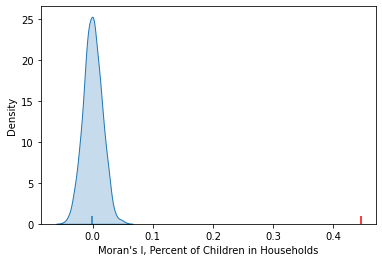

In [40]:
seaborn.kdeplot(moran.sim, shade=True)
plt.vlines(moran.I, 0, 1, color='r')
plt.vlines(moran.EI, 0,1)
plt.xlabel("Moran's I, Percent of Children in Households")


In [42]:
# Display on table for all variables
mi_results = [Moran(tracts_2[variable], w, two_tailed=True) for variable in cluster_variables]

table = pd.DataFrame([(variable, res.I, res.p_sim, res.z_sim, res.EI_sim, res.seI_sim) \
                          for variable,res \
                          in zip(cluster_variables, mi_results)
                         ], columns=['Variable', "Moran's I", 'P-value', 'Z-score', 'Mean', 'Std. dev']
                        )\
              .set_index('Variable')
table

,Moran's I,P-value,Z-score,Mean,Std. dev
Variable,,,,,
percent_f_hh,0.447021,0.001,28.846160,-0.001046,0.015533
percent_children_hh,0.445927,0.001,27.548211,-0.000870,0.016219
percent_no_vehicle,0.568243,0.001,35.175141,-0.001200,0.016189


Appears there is modest positive spatial autocorrelation for each of the variables. Percent no vehicle the strongest of the 3--possibly because this variable could also be measuring income?


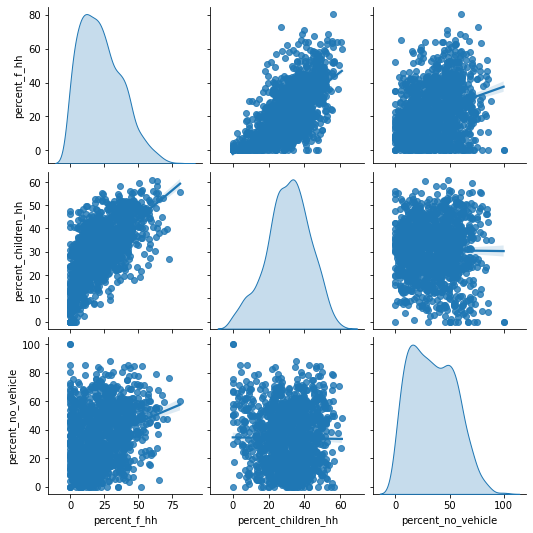

In [16]:
#Looking at relations between variables
_ = seaborn.pairplot(tracts_2[cluster_variables], kind='reg', diag_kind='kde')

Some positive correlation between percent of children in households and percent of households with female householders. Not surprising!

## K MEANS

In [49]:
#elbow method to determine optimal number of clusters

#scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(tracts_2[['percent_f_hh',
                                             'percent_children_hh',
                                             'percent_no_vehicle']])

distortions = []
K = range(2,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(scaled_data)
    distortions.append(kmeanModel.inertia_)

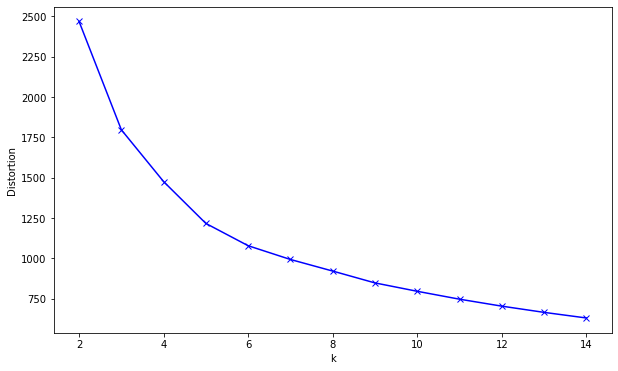

In [51]:
#plot
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

The elbow is at 4--tried 4 but 5 ended up having better reults.

In [80]:
##k means clustering

kmeans = KMeans(n_clusters=5)

#kmeans.fit(phl_tracts)
kmeans.fit(scaler.fit_transform(tracts_2[['percent_f_hh',
                                             'percent_children_hh',
                                             'percent_no_vehicle']]))

tracts_2['label'] = kmeans.labels_

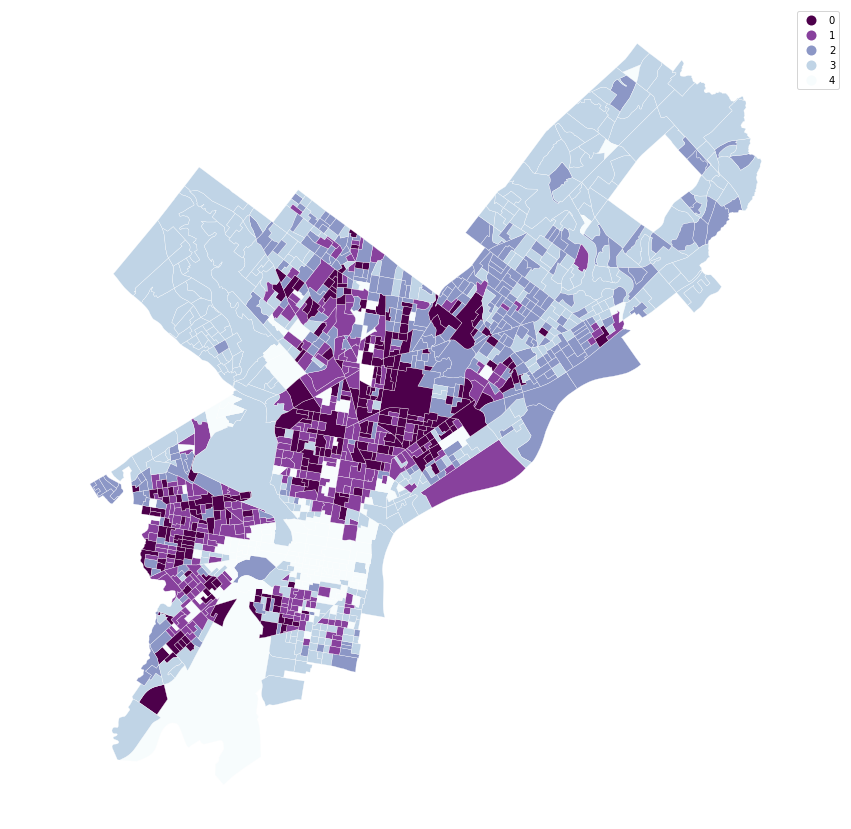

In [81]:
# setup the figure
f, ax = plt.subplots(figsize=(15, 15))

# plot, coloring by label column
# specify categorical data and add legend
tracts_2.plot(
    column="label",
    cmap="BuPu_r",
    categorical=True,
    legend=True,
    edgecolor="white",
    lw=0.3,
    ax=ax,
)


ax.set_axis_off()
plt.axis("equal");

In [57]:
url = "https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson"
census_t = gpd.read_file(url)
census_t = census_t.to_crs(epsg=3857)

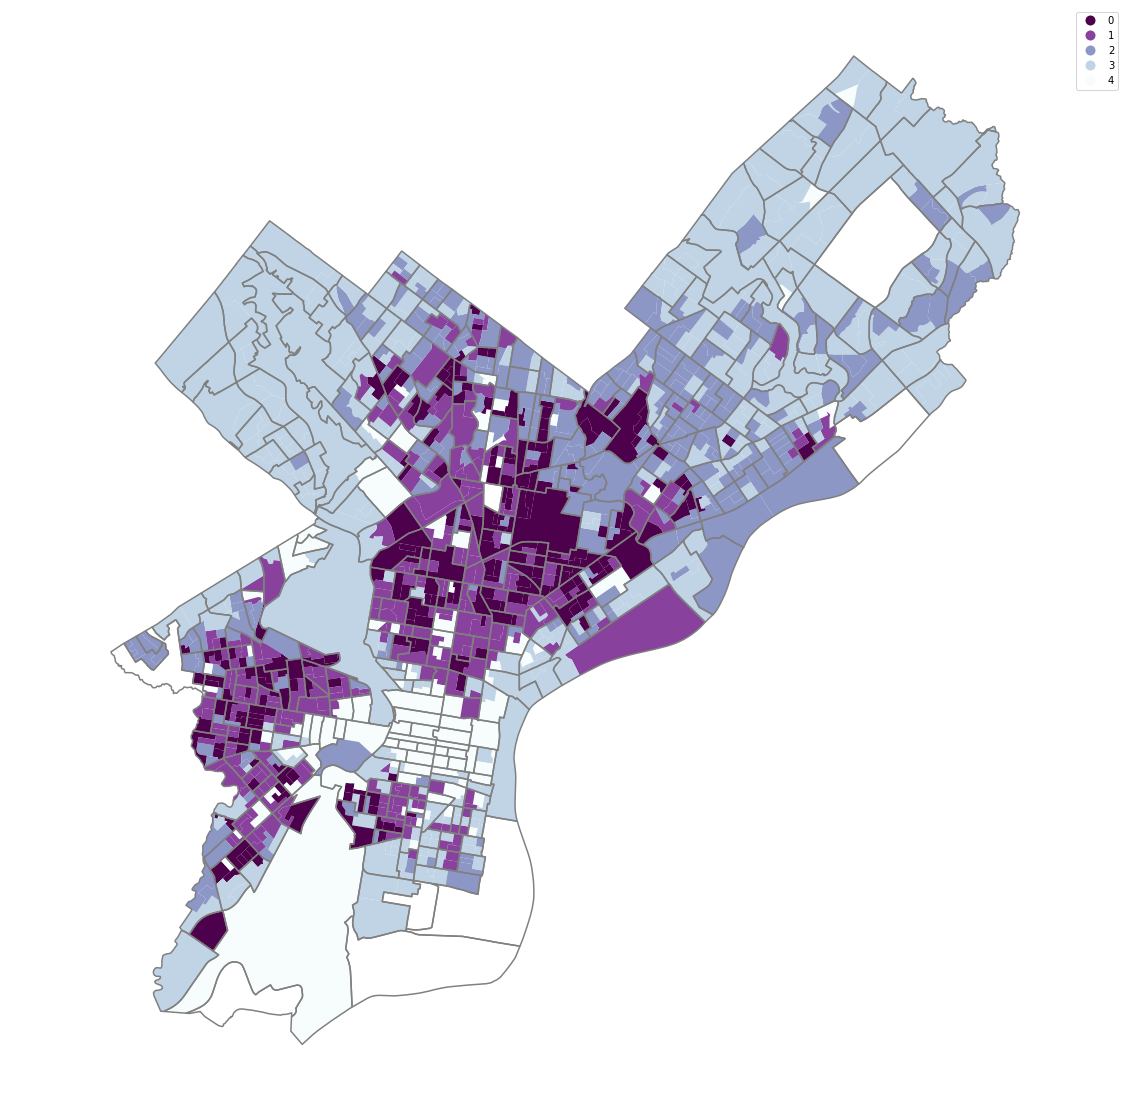

In [82]:
# setup the figure
f, ax = plt.subplots(figsize=(20, 20))

# plot, coloring by label column
# specify categorical data and add legend
tracts_2.plot(
    column="label",
    cmap="BuPu_r",
    categorical=True,
    legend=True,
    edgecolor="k",
    lw=0,
    ax=ax,
)

census_t.plot(
    facecolor="none",
    edgecolor="gray",
    lw=1.5,
    ax=ax,
)

ax.set_axis_off()
plt.axis("equal");

In [83]:
k4means = tracts_2.groupby('label')[cluster_variables].mean()
k4means.T.round(3)

label,0,1,2,3,4
percent_f_hh,45.772,23.976,25.366,10.402,5.627
percent_children_hh,43.231,29.422,38.939,24.608,10.403
percent_no_vehicle,49.461,52.412,19.541,15.516,49.497


In [60]:
#find mean of all blocks

In [84]:
# Index db on cluster ID
tidy_db = tracts_2.set_index('label')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db.head()

,label,Attribute,Values
0,1,percent_f_hh,14.691943
1,1,percent_children_hh,23.321555
2,1,percent_no_vehicle,39.336493
3,0,percent_f_hh,43.414634
4,0,percent_children_hh,40.576497


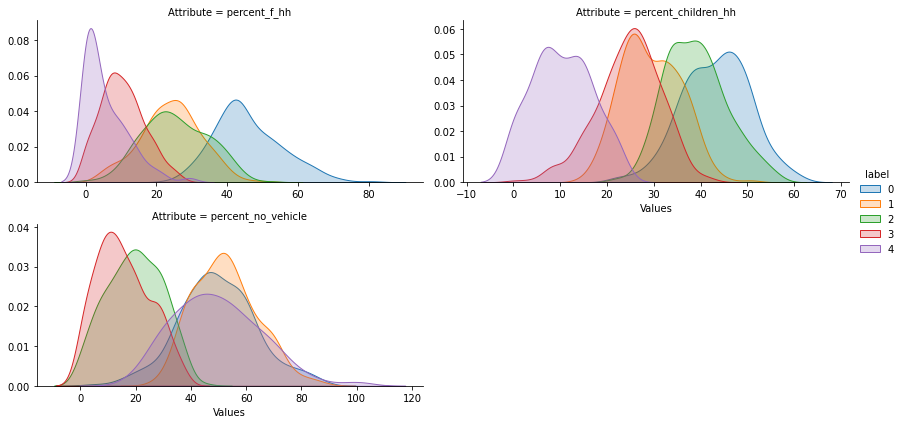

In [85]:
# Looking at density distributions of each variable in the clusters
facets = seaborn.FacetGrid(data=tidy_db, col='Attribute', hue='label', \
                  sharey=False, sharex=False, aspect=2, col_wrap=2)

_ = facets.map(seaborn.kdeplot, 'Values', shade=True).add_legend()

In [86]:
tracts_3 = pd.DataFrame(tracts_2)
tracts_3.head()

,OBJECTID,tract,block group,GEOID10,ALAND10,INTPTLAT10,INTPTLON10,Shape__Area,Shape__Length,geometry,...,pop_nf_fchild,tot_hh,state,county,hu_no_veh,pop_children,percent_f_hh,percent_children_hh,percent_no_vehicle,label
0,1,010800,1,421010108001,161887,+39.9687580,-075.1997251,1.742508e+06,8200.327170,"POLYGON ((-8371060.374 4861503.694, -8370941.2...",...,0.0,211.0,42,101,83.0,132.0,14.691943,23.321555,39.336493,1
1,2,010800,2,421010108002,103778,+39.9665475,-075.2004455,1.117026e+06,4364.980144,"POLYGON ((-8370984.565 4860959.884, -8371232.9...",...,0.0,205.0,42,101,114.0,366.0,43.414634,40.576497,55.609756,0
2,3,010900,2,421010109002,43724,+39.9642929,-075.1896435,4.706347e+05,3048.109084,"POLYGON ((-8369851.667 4860784.140, -8369840.0...",...,0.0,137.0,42,101,107.0,192.0,29.927007,41.921397,78.102190,1
3,4,011000,2,421010110002,108966,+39.9753585,-075.2113476,1.172871e+06,5169.004282,"POLYGON ((-8372320.622 4862094.017, -8372585.2...",...,0.0,329.0,42,101,243.0,285.0,6.079027,40.772532,73.860182,1
4,5,011000,1,421010110001,142244,+39.9724202,-075.2051689,1.531076e+06,10476.574129,"POLYGON ((-8371064.159 4862063.657, -8371063.7...",...,0.0,185.0,42,101,126.0,270.0,64.324324,55.327869,68.108108,0


In [87]:
#Calculating total number of blocks per tract for calculation
census = tracts_3.groupby("tract").agg(
    base = pd.NamedAgg(column="block group", aggfunc="count"),
    counts = pd.NamedAgg(column="label", aggfunc=lambda x: x[x == 0].count()))
census

,base,counts
tract,,
000100,2,0
000200,1,0
000300,2,0
000401,1,0
000402,2,0
...,...,...
039000,8,4
980000,1,0
980100,1,0


<AxesSubplot:>

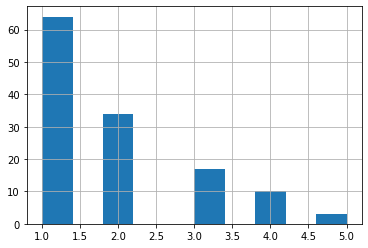

In [88]:
selections = census[census["counts"] > 0]
selections['counts'].hist()

In [89]:
selections['proportion'] = (selections['counts']/selections['base']) * 100
selections

/opt/miniconda3/envs/thesis-21/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,base,counts,proportion
tract,,,
001300,5,1,20.000000
003001,5,1,20.000000
003200,6,2,33.333333
003300,6,4,66.666667
003600,4,2,50.000000
...,...,...,...
033000,7,1,14.285714
037700,3,1,33.333333
038200,3,1,33.333333


In [90]:
from sklearn import preprocessing
# Get column names first
names = selections.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(selections)
scaled_df = pd.DataFrame(scaled_df, columns=names)


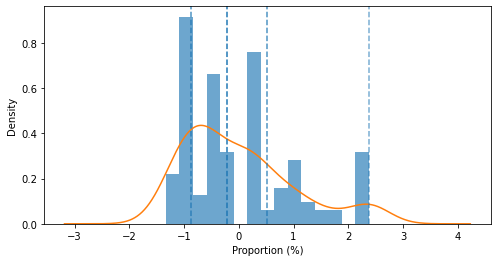

In [92]:
dat = scaled_df["proportion"]
fig, ax = plt.subplots(figsize = (8,4))

# Plots #
    # Plot histogram
dat.plot(kind = "hist", density = True,alpha = 0.65, bins = 15) # change density to true, because KDE uses density
    # Plot KDE
dat.plot(kind = "kde")

# X #
ax.set_xlabel("Proportion (%)")

quant_25, quant_50, quant_75, quant_95 = dat.quantile(0.25), dat.quantile(0.5), dat.quantile(0.75), dat.quantile(0.95)

# [quantile, opacity, length]
quants = [quant_25, 0.8, 0.26], [quant_50, 1, 0.36],  [quant_75, 0.8, 0.46], [quant_95, 0.6, 0.56]

# Plot the lines with a loop
for i in quants:
    ax.axvline(i[0], alpha = i[1], linestyle = "--")

plt.show()

In [94]:
quant_75

0.5225529402400689

In [95]:
final_select = selections[selections["proportion"] > 57.14]
final_select.head()

,base,counts,proportion
tract,,,
003300,6,4,66.666667
003701,5,3,60.000000
005600,1,1,100.000000
006200,4,4,100.000000
008102,5,3,60.000000


In [96]:
census_t = census_t.rename(columns={'TRACTCE10': 'tract'})
tracts_FINAL = census_t.merge(final_select, on=['tract'])
len(tracts_FINAL)

33

33 tracts! Will need to be narrowed down.

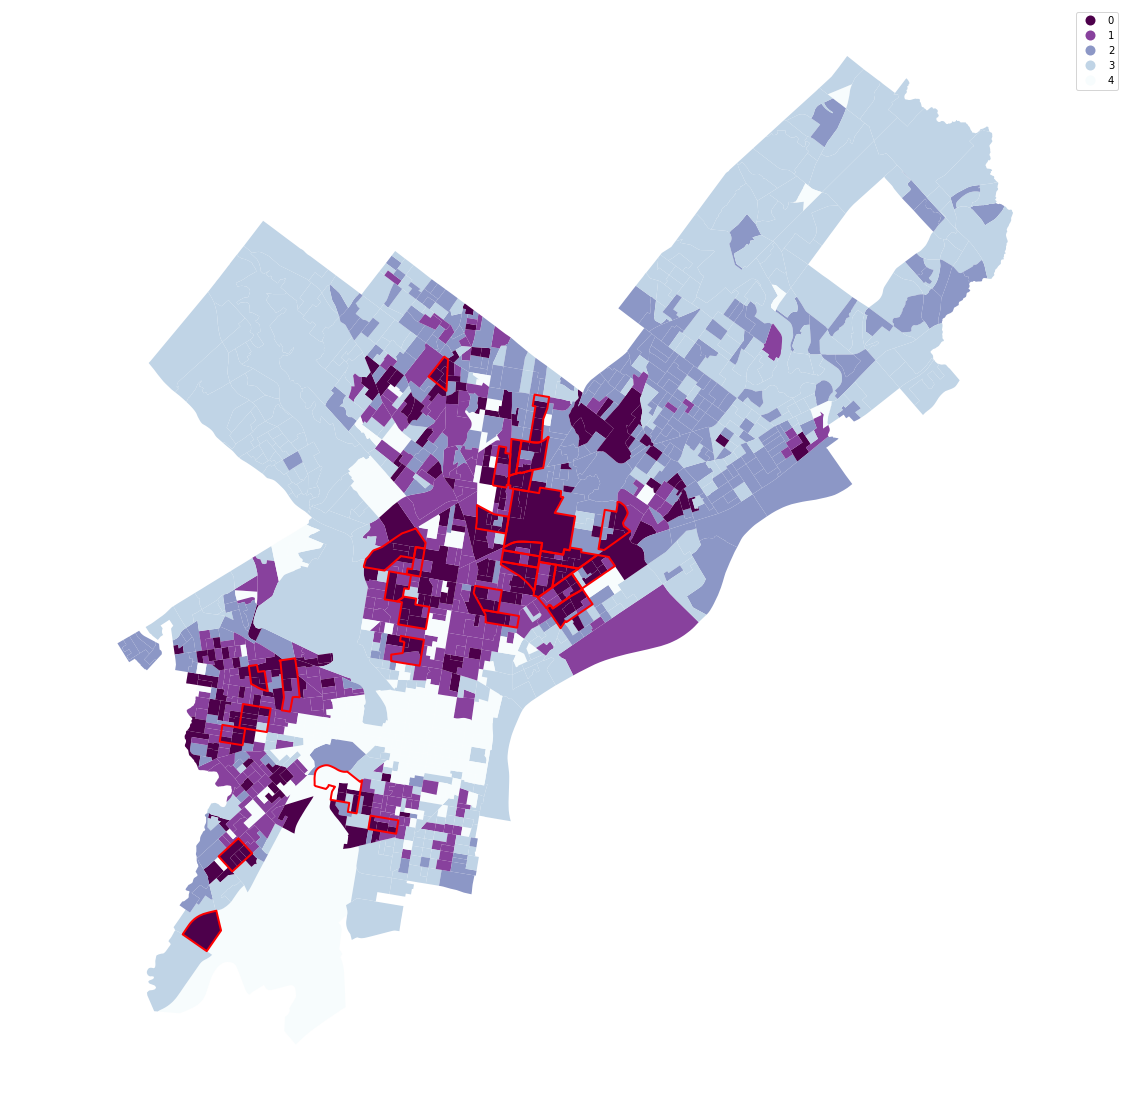

In [97]:
#setup the figure
f, ax = plt.subplots(figsize=(20, 20))

# plot, coloring by label column
# specify categorical data and add legend
tracts_2.plot(
    column="label",
    cmap="BuPu_r",
    categorical=True,
    legend=True,
    edgecolor="k",
    lw=0,
    ax=ax,
)

tracts_FINAL.plot(
    facecolor="none",
    edgecolor="red",
    lw=2,
    ax=ax,
)

ax.set_axis_off()
plt.axis("equal");

Selection of the 33 tracts containing the highest proportion of block groups with the variables of interest(no access to vehicles, high percetnage of children, high percentage of female householders).

# PAIRING

In [43]:
trips = pd.read_csv("/Users/camilleboggan/Documents/University of Pennsylvania/Fall 2020/Thesis/data/PublicDB_RELEASE/DVRPC HTS Database Files/4_Trip_Public.csv")

81940

In [41]:
hh = pd.read_csv("/Users/camilleboggan/Documents/University of Pennsylvania/Fall 2020/Thesis/data/PublicDB_RELEASE/DVRPC HTS Database Files/1_Household_Public.csv")
hh.head(5)

,ID,HH_ID,HH_WEIGHT,HH_GEO_ACC,H_STATE,H_COUNTY,H_CPA,H_MCD,H_TRACT,H_TAZ,...,TRAV_DATE,TRAV_DOW,HOLIDAY,HOL_TYPE,OV_SAMPLE,STUDY,RECRUIT,RETRIEVE,R_LANG,SURV_LANG
0,1,100140,133.460324,1,34,34005,005_702,3400543740,34005700405,20225,...,8/3/2012,5,NaN,0,1,1,1,3,1,1
1,2,100206,204.106167,1,34,34005,005_702,3400547880,34005700501,20249,...,8/2/2012,4,NaN,0,0,1,1,3,1,1
2,3,100291,287.910549,1,34,34005,005_701,3400517440,34005700603,20048,...,7/31/2012,2,NaN,0,0,1,1,3,1,1
3,4,100355,222.444138,1,34,34005,005_701,3400517080,34005700800,20042,...,8/8/2012,3,NaN,0,0,1,1,2,1,1
4,5,100374,365.146458,1,34,34005,005_701,3400505740,34005700900,20002,...,8/2/2012,4,NaN,0,1,1,1,3,1,1
